<a href="https://colab.research.google.com/github/nguyetvo/CBD-Fruits360/blob/master/VGG16_Pretrain_Fruits360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fruits360 - Multiclass classification of fruits &amp; vegitable images (using Keras)
* This workbook illustrates my attempt to solve the [Kaggle Fruits360 challenge](https://www.kaggle.com/moltean/fruits).
* I'll be using Keras on Tensorflow (actually Tensorflow's implementation of Keras, available in `tf.keras` package).
* I will be using the VGG16 pre-trained model, which is a complex CNN trained on the ImageNet image set.

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nguyetvo1010","key":"b4358117b762b9b20a9246f5c6c51c40"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d moltean/fruits

100% 758M/760M [00:05<00:00, 163MB/s]
100% 760M/760M [00:05<00:00, 146MB/s]


In [5]:
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg

In [6]:
!ls

fruits-360  fruits.zip	kaggle.json  sample_data


In [7]:
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

import sys, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import cv2
print('Using OpenCV version ', cv2.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
%matplotlib inline

USING_TF2 = (tf.__version__.startswith('2'))

plt.style.use('seaborn')
sns.set_style('darkgrid')

float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=110)

seed = 123
random.seed(seed)
np.random.seed(seed)
if USING_TF2:
    tf.random.set_seed(seed)
else:
    tf.set_random_seed(seed)

train_folder_root = '/content/fruits-360/Training'
test_folder_root = '/content/fruits-360/Test'

Using Tensorflow version  2.2.0
Using OpenCV version  4.1.2


In [8]:
# a quick dict of category-id to category-name (category name is parent folder under which image is present)
fruit_category_names = sorted(os.listdir(train_folder_root))
fruit_categories = {}
for i, name in enumerate(fruit_category_names):
    fruit_categories[i] = name

NUM_CLASSES = len(fruit_categories.keys())
print('Detected %d classes' % NUM_CLASSES)

Detected 131 classes


### Utility Functions
Some utility functions we will use in this workbook

In [9]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=8, num_cols=8,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns
    assert len(sample_images) == num_rows * num_cols

    # a dict to help encode/decode the labels
    global fruit_categories
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 12) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.93)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                pil_image = sample_images[image_index] #Image.fromarray(sample_images[image_index])
                ax[r, c].imshow(pil_image)
                
                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % fruit_categories[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = fruit_categories[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (fruit_categories[true_label][:5], fruit_categories[pred_label][:5])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [10]:
def show_plots(history, plot_title=None, fig_size=None):
    
    import seaborn as sns
    
    """ Useful function to view plot of loss values & accuracies across the various epochs
        Works with the history object returned by the train_model(...) call """
    assert type(history) is dict

    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    
    # accuracy is an optional metric chosen by user
    # NOTE: in Tensorflow 2.0, the keys are 'accuracy' and 'val_accuracy'!! Why Google?? Why!!??
    acc_vals = history['acc'] if 'acc' in history.keys() else None
    if acc_vals is None:
        # try 'accuracy' key, as used by the Tensorflow 2.0 backend
        acc_vals = history['accuracy'] if 'accuracy' in history.keys() else None
        
    assert acc_vals is not None, "Something wrong! Cannot read 'acc' or 'accuracy' from history.keys()"
        
    val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None
    if val_acc_vals is None:
        # try 'val_accuracy' key, could be using Tensorflow 2.0 backend!
        val_acc_vals = history['val_accuracy'] if 'val_accuracy' in history.keys() else None    
        
    assert val_acc_vals is not None, "Something wrong! Cannot read 'val_acc' ot 'val_acuracy' from history.keys()"
        
    epochs = range(1, len(history['loss']) + 1)
    
    col_count = 1 if ((acc_vals is None) and (val_acc_vals is None)) else 2
    
    with sns.axes_style("darkgrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(nrows=1, ncols=col_count, figsize=((16, 5) if fig_size is None else fig_size))
    
        # plot losses on ax[0]
        #ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
        ax[0].plot(epochs, loss_vals, label='Training Loss')
        if val_loss_vals is not None:
            #ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
            ax[0].plot(epochs, val_loss_vals, label='Validation Loss')
            ax[0].set_title('Training & Validation Loss')
            ax[0].legend(loc='best')
        else:
            ax[0].set_title('Training Loss')
    
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].grid(True)
    
        # plot accuracies, if exist
        if col_count == 2:
            #acc_vals = history['acc']
            #val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None

            #ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
            ax[1].plot(epochs, acc_vals, label='Training Accuracy')
            if val_acc_vals is not None:
                #ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
                ax[1].plot(epochs, val_acc_vals, label='Validation Accuracy')
                ax[1].set_title('Training & Validation Accuracy')
                ax[1].legend(loc='best')
            else:
                ax[1].set_title('Training Accuracy')

            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Accuracy')
            ax[1].grid(True)
    
        if plot_title is not None:
            plt.suptitle(plot_title)
    
        plt.show()
        plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals

In [11]:
def save_keras_model(model, base_file_name, save_dir=os.path.join('.', 'model_states')):
    """ save everything to one HDF5 file """
    
    # save the model
    if not base_file_name.lower().endswith('.h5'):
        base_file_name = base_file_name + '.h5'

    # base_file_name could be just a file name or complete path
    if (len(os.path.dirname(base_file_name)) == 0):
        # only file name specified e.g. kr_model.h5. We'll use save_dir to save
        if not os.path.exists(save_dir):
            # check if save_dir exists, else create it
            try:
                os.mkdir(save_dir)
            except OSError as err:
                print("Unable to create folder {} to save Keras model. Can't continue!".format(save_dir))
                raise err
        model_save_path = os.path.join(save_dir, base_file_name)
    else:
        # user passed in complete path e.g. './save_states/kr_model.h5'
        model_save_path = base_file_name
        
    #model_save_path = os.path.join(save_dir, base_file_name)
    model.save(model_save_path)
    print('Saved model to file %s' % model_save_path)
    
def load_keras_model(base_file_name, save_dir=os.path.join('.', 'model_states'), 
                     custom_metrics_map=None, use_tf_keras_impl=True):
                
    """load model from HDF5 file"""
    if not base_file_name.lower().endswith('.h5'):
        base_file_name = base_file_name + '.h5'
        
    # base_file_name could be just a file name or complete path
    if (len(os.path.dirname(base_file_name)) == 0):
        # only file name specified e.g. kr_model.h5
        model_save_path = os.path.join(save_dir, base_file_name)
    else:
        # user passed in complete path e.g. './save_states/kr_model.h5'
        model_save_path = base_file_name

    if not os.path.exists(model_save_path):
        raise IOError('Cannot find model state file at %s!' % model_save_path)
        
    # load the state/weights etc.
    if use_tf_keras_impl:
        from tensorflow.keras.models import load_model 
    else:
        from keras.models import load_model

    # load the state/weights etc. from .h5 file        
    # @see: https://github.com/keras-team/keras/issues/3911
    # useful when you have custom metrics
    model = load_model(model_save_path, custom_objects=custom_metrics_map)
    print('Loaded Keras model from %s' % model_save_path)
    return model

### Training our Model
We will use ImageDataGenerator to read images off disk & a pre-trained VGG16 model for classification.

In [12]:
# hyper-parameters for training
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS = 100, 100, 3
LR_START, LR_WEIGHT_DECAY = 0.001, 1e-4
NUM_EPOCHS, BATCH_SIZE = 30, 128
MODEL_SAVE_DIR = './model_states'

In [13]:
# we will use Keras' ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1.0/255,
#     rotation_range=20,
# 	zoom_range=0.05,
# 	width_shift_range=0.05,
# 	height_shift_range=0.05,
# 	shear_range=0.05,
# 	horizontal_flip=True,
# 	fill_mode="nearest")

train_datagen = ImageDataGenerator(rescale=1.0/255)
# I am splitting test dataset into cross-val & test datasets in 70:30 ratio 
# (since both should ideally be drawn from same population)
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.3)

# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

eval_generator = test_datagen.flow_from_directory(
    train_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='training')

test_generator = test_datagen.flow_from_directory(
    test_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    subset='validation')

# calculate training/cross-val and testing steps
train_steps = train_generator.n // BATCH_SIZE
eval_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

print('Training set size %d, step-size %d' % (train_generator.n, train_steps))
print('Cross-val set size %d, step-size %d' % (eval_generator.n, eval_steps))
print('Test set size %d, step-size %d' % (test_generator.n, test_steps))

Found 67692 images belonging to 131 classes.
Found 47427 images belonging to 131 classes.
Found 6744 images belonging to 131 classes.
Training set size 67692, step-size 528
Cross-val set size 47427, step-size 370
Test set size 6744, step-size 52


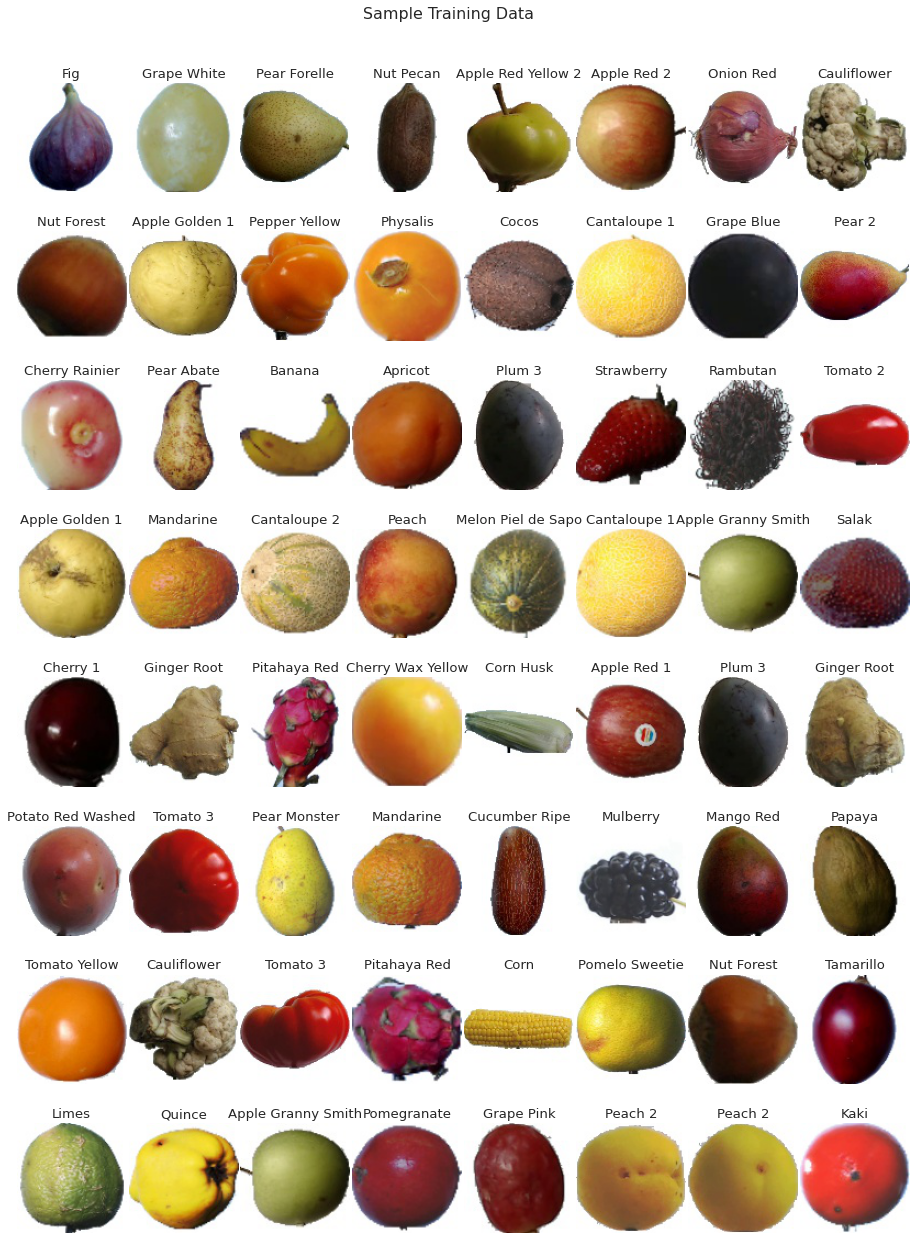

In [14]:
# display a sample from the training dataset
images, labels = train_generator.next()
labels = np.argmax(labels, axis=1)
display_sample(images[:64], labels[:64], num_rows=8, num_cols=8, 
               plot_title='Sample Training Data', fig_size=(16,20))

## Using the VGG16 pre-trained model
In this section we will use the VGG16 model's Convolutional part & discard the Dense part (predictor). We will add our custom 'predictor' part atop the convolutional layers

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()  # tf.reset_default_graph()

# NOTE: will download the weights for imagenet
vgg16_base = VGG16(
    weights='imagenet',    # use weights for ImageNet
    include_top=False,     # don't use upper Dense layers
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg16_base.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
______________________________________________________________

In [16]:
def build_model_vgg16(use_l2_loss=True):
    from tensorflow.keras.optimizers import Adam, SGD
    from tensorflow.keras.regularizers import l2
    
    l2_loss_lambda = 0.00002  # just a wee-bit :)
    l2_loss = l2(l2_loss_lambda) if use_l2_loss else None
    if l2_loss is not None: print('Using l2_loss_lambda = %f' % l2_loss_lambda)
        
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before) 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),      
        tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),        
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2_loss),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    
    ])
    
    # mark vgg16-base layer as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg16_base.trainable = False
    
    adam = Adam(lr=LR_START)
    sgd = SGD(lr=1e-1, momentum=0.9, decay=1e-1 / NUM_EPOCHS)
    
    model.compile(optimizer=sgd, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
try:
    del model
except NameError:
    pass # model is not defined!

model = build_model_vgg16()
print(model.summary())

Using l2_loss_lambda = 0.000020
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              9439232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)     

In [18]:
# train the model
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_step(epoch, curr_lr):
    power = (epoch % 5) # [0-19] = 0, [20-39] = 1, [40-59] = 2...
    new_lr = LR_START * 1.0 / (1 + 0.01 * power)
    return new_lr

lr_callback = LearningRateScheduler(lr_step, verbose=1)

# train model on generator
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=NUM_EPOCHS,
    validation_data=eval_generator,
    validation_steps=eval_steps,
    workers=3,
    #callbacks=[lr_callback]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
528/528 [==============================] - 245s 464ms/step - loss: 2.3947 - accuracy: 0.3955 - val_loss: 0.6621 - val_accuracy: 0.8226
Epoch 2/30
528/528 [==============================] - 243s 459ms/step - loss: 0.7551 - accuracy: 0.7922 - val_loss: 0.2725 - val_accuracy: 0.9525
Epoch 3/30
528/528 [==============================] - 242s 459ms/step - loss: 0.4518 - accuracy: 0.8867 - val_loss: 0.2014 - val_accuracy: 0.9755
Epoch 4/30
528/528 [==============================] - 242s 459ms/step - loss: 0.3302 - accuracy: 0.9267 - val_loss: 0.1529 - val_accuracy: 0.9912
Epoch 5/30
528/528 [==============================] - 242s 459ms/step - loss: 0.2772 - accuracy: 0.9458 - val_loss: 0.1391 - val_accuracy: 0.9947
Epoch 6/30
528/528 [==============================] - 243s 460ms/step - loss: 0.2447 - accuracy: 0.9571 - val_loss: 0.1372 - val_accuracy: 0.9942
Epoch 7/30
528/528 [============================

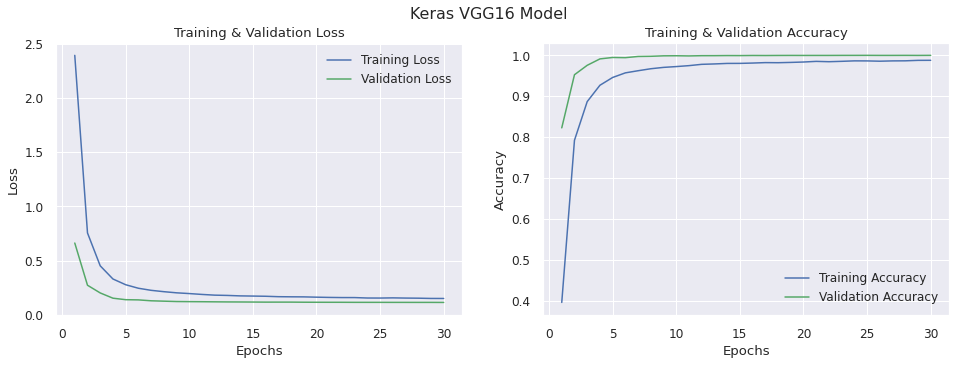

In [19]:
show_plots(hist.history, "Keras VGG16 Model")

In [20]:
# evaluate performance on train, cross-val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(eval_generator, steps=eval_steps, verbose=1, workers=3)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
528/528 [==============================] - 141s 267ms/step - loss: 0.1132 - accuracy: 0.9999
Training data  -> loss: 0.113, acc: 1.000
370/370 [==============================] - 98s 266ms/step - loss: 0.1136 - accuracy: 0.9999
Cross-val data -> loss: 0.114, acc: 1.000
52/52 [==============================] - 14s 263ms/step - loss: 0.1432 - accuracy: 0.9917
Testing data   -> loss: 0.143, acc: 0.992


* We got training & cross-validation accuracies = 100%
* Training accuracy is 99% (almost 100%)


In [21]:
save_keras_model(model, "nguyet_fruits360_vgg16", MODEL_SAVE_DIR)
del model

Saved model to file ./model_states/nguyet_fruits360_vgg16.h5


### Running Predictions from the trained model
The training epochs learnt weights of the Dense layers, which we inserted atop the base VGG16 convolutional 

In [22]:
model = load_keras_model("nguyet_fruits360_vgg16", MODEL_SAVE_DIR)
print(model.summary())

Loaded Keras model from ./model_states/nguyet_fruits360_vgg16.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              9439232   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________

In [23]:
print('Running predictions...')

test_generator = test_datagen.flow_from_directory(
    test_folder_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

all_predictions, all_labels = [], []
for i in range(test_steps):
    images, labels = test_generator.next()
    labels = np.argmax(labels, axis=1)
    y_pred = np.argmax(model.predict(images), axis=1)
    all_predictions.extend(y_pred.astype('int32'))
    all_labels.extend(labels.astype('int32'))

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print('First 25 results:')
print('  - Actuals    : ', all_labels[:25])
print('  - Predictions: ', all_predictions[:25])
correct_pred_count = (all_labels == all_predictions).sum()
test_acc = correct_pred_count / len(all_labels)
print('We got %d of %d correct (or %.3f accuracy)' % (correct_pred_count, len(all_labels), test_acc))

Running predictions...
Found 6744 images belonging to 131 classes.
First 25 results:
  - Actuals    :  [ 23  85 107 128  69  64 117  67  82  52 130  24 123  62  17  89  99   0 127  58  18   5  33  65  35]
  - Predictions:  [ 23  85 107 128  69  64 117  67  82  52 130  24 123  62  17  89  99   0 127  58  18   5  33  65  35]
We got 6604 of 6656 correct (or 0.992 accuracy)


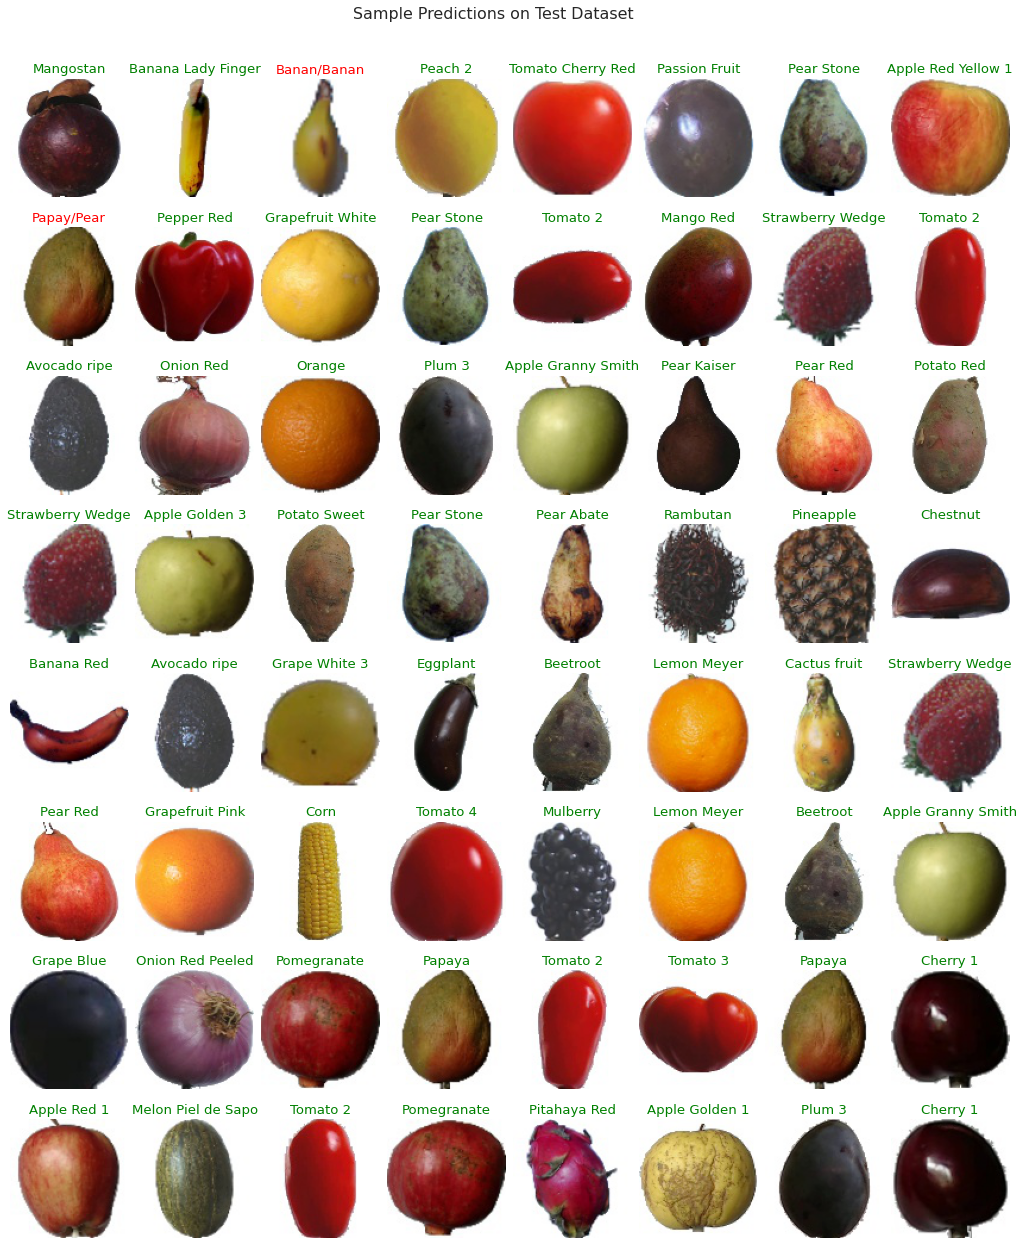

In [24]:
# display sample predictions
images, labels = test_generator.next()
labels = np.argmax(labels, axis=1)
predictions = np.argmax(model.predict(images), axis=1)
display_sample(images[:64], labels[:64], sample_predictions=predictions[:64], num_rows=8, num_cols=8, 
               plot_title='Sample Predictions on Test Dataset', fig_size=(18,20))

**Observations:**

>Configuration | Training Acc | Cross-Val Acc | Testing Acc 
>:---|:---:|:---:|:---:|
>**VGG16 Base Model**|100%|100%|99.1%|

* From the loss & accuracy plots, we see that the model trails the validation metrics for almost all epochs before 'catching up'.
* We appear to have achieved the impossible :)! A near perfect model - with 100% training accuracy & almost 100% test accuracy.

# <center> -- END -- </center>